# [Experiment] The learned features extract identity information #

## Oerview ##

|Model|People|Training images|Validation images|Iteration|Top-1 accuracy on validation set|Test accuracy on LFW with Joint Bayesian method|
| ----|----|----- |----- |
|62x62_3_e2_8460|8,460|284,466|27,498|750,000|0.666424|0.66|

## Result ##

![same_identity_pair_0.png](./same_identity_pair_0.png)

![same_identity_pair_1.png](./same_identity_pair_1.png)

![different_identity_pair_0.png](./different_identity_pair_0.png)

![different_identity_pair_1.png](./different_identity_pair_1.png)

## What's the Different ##

||Paper|This Experiment|
| ----|----|----|
|Dataset|CelebFace|CASIA-WebFace|
|Facial point detection|[30]|custom tool|
|Input size|31x31 or 39x31|62x62|
|(Weights) Locally shared|C3, C4|no|

- [30] Y.Sun, X.Wang, andX.Tang. [Deep convolutional network cascade for facial point detection.](http://www.ee.cuhk.edu.hk/~xgwang/papers/sunWTcvpr13.pdf) In Proc. CVPR, 2013
- [D.5.1.3 The learned features extract identity information](../../DeepID.ipynb#D.5.1.3-The-learned-features-extract-identity-information)

## Process ##

1. [Train ConvNet](#Train-ConvNets-with-264,-528,-1057,-2115,-4230,-8460-people-respectively)
2. [Model selection](#Model-selection)
3. [Extract DeepIDs of LFW people](#Extract-DeepIDs-of-LFW-people)
3. [Plot sparsity patterns of DeepIDs](#Plot-sparsity-patterns-of-DeepIDs)

**Tips**

- [How do you change the size of figures drawn with matplotlib?](http://stackoverflow.com/questions/332289/how-do-you-change-the-size-of-figures-drawn-with-matplotlib)
- [How to draw a matrix sparsity pattern with color code in python?](http://stackoverflow.com/questions/24013962/how-to-draw-a-matrix-sparsity-pattern-with-color-code-in-python)

## Train ConvNet ##


- [Train model_62x62_3_e2_8460](../../model_62x62_3_e2_8460/train.ipynb)

## Model selection ##

[back to top](#Process)

**model_62x62_3_e2_8460**

- top-1 accuracy on validation set from [Train model_62x62_3_e2_8460](../../model_62x62_3_e2_8460/train.ipynb#Choose-Best-model)

```
The model in iter:  50000.0  top-1 accuracy: 0.537936
The model in iter:  100000.0  top-1 accuracy: 0.566461
The model in iter:  150000.0  top-1 accuracy: 0.580305
The model in iter:  200000.0  top-1 accuracy: 0.587391
The model in iter:  250000.0  top-1 accuracy: 0.595312
The model in iter:  300000.0  top-1 accuracy: 0.597711
The model in iter:  350000.0  top-1 accuracy: 0.601344
The model in iter:  400000.0  top-1 accuracy: 0.595603
The model in iter:  400000.0  top-1 accuracy: 0.59673
The model in iter:  450000.0  top-1 accuracy: 0.646693
The model in iter:  500000.0  top-1 accuracy: 0.652544
The model in iter:  550000.0  top-1 accuracy: 0.653997
The model in iter:  600000.0  top-1 accuracy: 0.657812
The model in iter:  650000.0  top-1 accuracy: 0.653888
The model in iter:  700000.0  top-1 accuracy: 0.652398
The model in iter:  750000.0  top-1 accuracy: 0.666424 <---- choose this
The model in iter:  800000.0  top-1 accuracy: 0.65952
The best model iter in process: 750000.0  top-1 accuracy: 0.666424
```

## Extract DeepIDs of LFW people ##

[back to top](#Process)

In [1]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import skimage
import sys
import caffe
import sklearn.metrics.pairwise as pw
from sklearn.datasets import fetch_lfw_pairs

/opt/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/opt/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Blob<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/opt/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Solver<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \


In [2]:
MODEL_FILE = '/workspace/tools/deepid/model/62x62_3_e2_8460/snapshot/snapshot_iter_750000.caffemodel'
DEPLOY_FILE = '/workspace/tools/deepid/model/62x62_3_e2_8460/deploy.prototxt'

caffe.set_mode_gpu()
net = caffe.Net(DEPLOY_FILE, MODEL_FILE, caffe.TEST)

In [3]:
lfwList = fetch_lfw_pairs(subset='10_folds', data_home='/workspace/datasets', funneled=True, resize=0.5, color=True, slice_=(slice(63, 187), slice(63, 187)), download_if_missing=True)

In [4]:
# pairs : numpy array of shape (6000, 2, 62, 62, 3)
# target : numpy array of shape (6000,)
leftParts = lfwList.pairs[:, 0, :, :, :]
rightParts = lfwList.pairs[:, 1, :, :, :]

assert(len(leftParts) == len(rightParts))

test_num = len(leftParts)

In [5]:
# load the mean image (as distributed with Caffe) for subtraction
mu = np.load('/workspace/datasets/CASIA-WebFace-custom/mean_8460_62x62.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values

In [6]:
# create transformer for the input called 'data_1'
transformer = caffe.io.Transformer({'data': net.blobs['data_1'].data.shape})

# (h,w,c) => (c,h,w)
transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_input_scale('data', 0.0078125)

In [7]:
print 'network input:', net.inputs
print 'network output:', net.outputs

network input: ['data_1']
network output: ['deepid_1']


In [8]:
X = np.empty((test_num, 3, 62, 62))

i = 0
for entry in leftParts:
    X[i, :, :, :] = transformer.preprocess('data', entry)
    i = i + 1

out = net.forward_all(data_1 = X)
feature1 = np.float64(out['deepid_1'])
feature1 = np.reshape(feature1, (test_num, 160))

In [9]:
X = np.empty((test_num, 3, 62, 62))

i = 0
for entry in rightParts:
    X[i, :, :, :] = transformer.preprocess('data', entry)
    i = i + 1

out = net.forward_all(data_1 = X)
feature2 = np.float64(out['deepid_1'])
feature2 = np.reshape(feature2, (test_num, 160))

In [10]:
labels = lfwList.target

assert(len(labels) == test_num)

same_person_pair = []
diff_person_pair = []

for i in range(labels.shape[0]):
    if labels[i] == 1:
        same_person_pair.append(i)
    else:
        diff_person_pair.append(i)

In [11]:
import random

random.shuffle(same_person_pair)
random.shuffle(diff_person_pair)

## Plot sparsity patterns of DeepIDs ##

[back to top](#Process)

### Same identity pair ###

In [12]:
import matplotlib.gridspec as gridspec

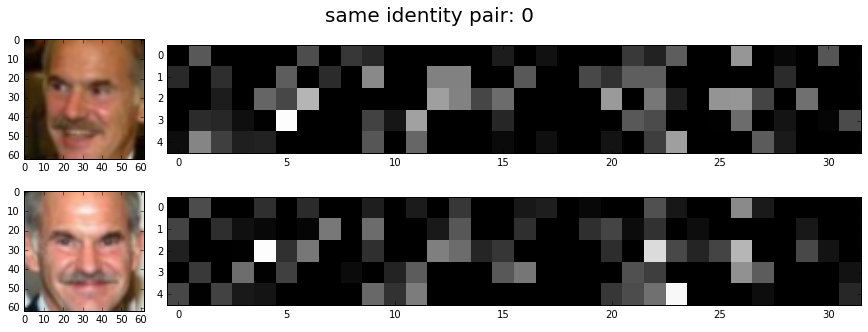

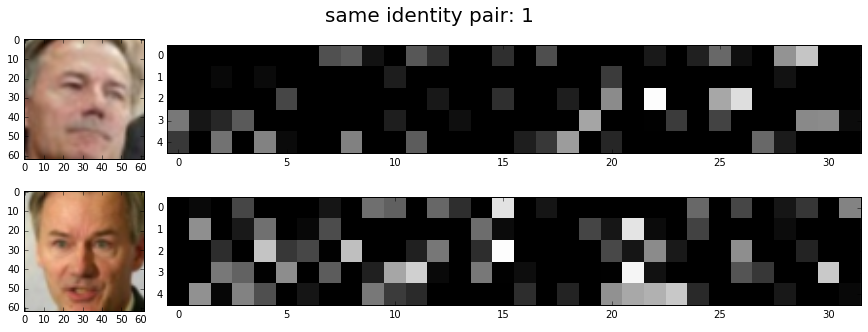

In [13]:
pair_num = 0
for index in same_person_pair[:2]:
    im_left = leftParts[index]
    im_left = im_left / 255

    im_right = rightParts[index]
    im_right = im_right / 255

    deepid_left = feature1[index]
    deepid_left = np.reshape(deepid_left, (5, 32))
    deepid_left = np.maximum(deepid_left, 0) # ReLU

    deepid_right = feature2[index]
    deepid_right = np.reshape(deepid_right, (5, 32))
    deepid_right = np.maximum(deepid_right, 0) # ReLU

    gs = gridspec.GridSpec(2, 6)
    plt.figure(num=pair_num, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
    title = 'same identity pair: ' + str(pair_num)
    plt.suptitle(title, fontsize=20)
    
    ax1 = plt.subplot(gs[0, 0])
    plt.imshow(im_left)
    ax2 = plt.subplot(gs[1, 0])
    plt.imshow(im_right)
    ax3 = plt.subplot(gs[0, 1:])
    plt.imshow(deepid_left, interpolation='none', cmap='binary_r')
    ax4 = plt.subplot(gs[1, 1:])
    plt.imshow(deepid_right, interpolation='none', cmap='binary_r')
    plt.savefig('./same_identity_pair_' + str(pair_num) + '.png')

    pair_num = pair_num + 1

### Different identity pair ###

In [14]:
import matplotlib.gridspec as gridspec

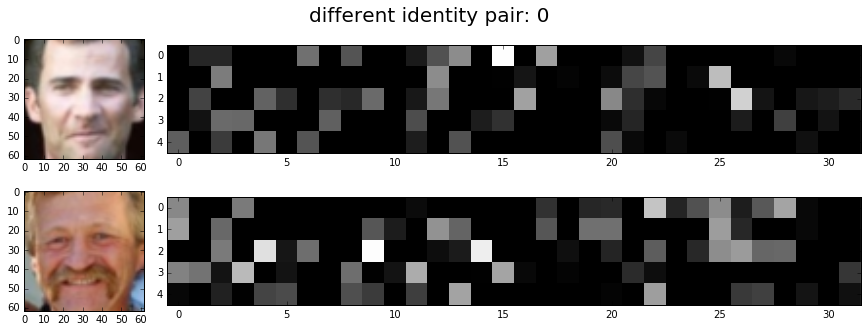

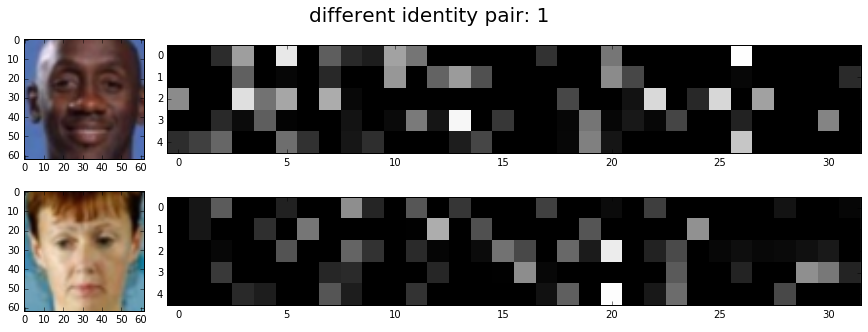

In [15]:
pair_num = 0
for index in diff_person_pair[:2]:
    im_left = leftParts[index]
    im_left = im_left / 255

    im_right = rightParts[index]
    im_right = im_right / 255

    deepid_left = feature1[index]
    deepid_left = np.reshape(deepid_left, (5, 32))
    deepid_left = np.maximum(deepid_left, 0) # ReLU

    deepid_right = feature2[index]
    deepid_right = np.reshape(deepid_right, (5, 32))
    deepid_right = np.maximum(deepid_right, 0) # ReLU

    gs = gridspec.GridSpec(2, 6)
    plt.figure(num=pair_num, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
    title = 'different identity pair: ' + str(pair_num)
    plt.suptitle(title, fontsize=20)
    
    ax1 = plt.subplot(gs[0, 0])
    plt.imshow(im_left)
    ax2 = plt.subplot(gs[1, 0])
    plt.imshow(im_right)
    ax3 = plt.subplot(gs[0, 1:])
    plt.imshow(deepid_left, interpolation='none', cmap='binary_r')
    ax4 = plt.subplot(gs[1, 1:])
    plt.imshow(deepid_right, interpolation='none', cmap='binary_r')
    plt.savefig('./different_identity_pair_' + str(pair_num) + '.png')

    pair_num = pair_num + 1